In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [22]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis"
)
#from my_dataset_maps_20_e import MapDatasetNuisanceE
#from  my_fit_20 import Fit
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation import sys_dataset
import upper_limit_18_02


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : f5f4ITBp 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : 3gjlvVHe
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model t

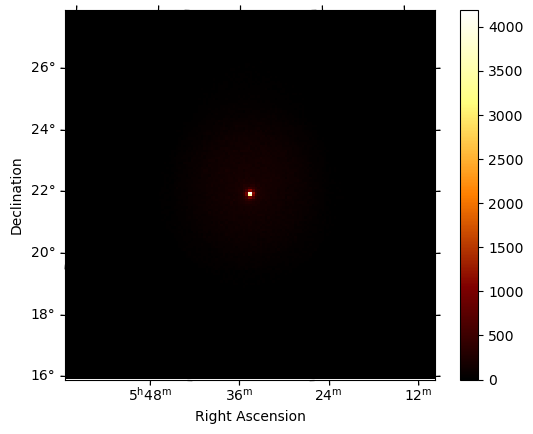

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy())

bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models
dataset_asimov.models[0].parameters['lon_0'].frozen = True
dataset_asimov.models[0].parameters['lat_0'].frozen = True
    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Single Cases

In [4]:
factors = np.array([-0.1])
sigma  =0.1
rnd = False
sys = sys_dataset(dataset_asimov, factors[0], rnd)
dataset_input = sys.create_dataset()


In [5]:
datasets = []
datasets_N = []

for i, factor in enumerate(factors):
    print(i, factor)
    sys = sys_dataset(dataset_asimov, factor, rnd)
    dataset = sys.create_dataset()
    dataset.models[0].parameters['lon_0'].frozen = True
    dataset.models[0].parameters['lat_0'].frozen = True
    datasets.append(dataset)

    dataset_N = sys.create_dataset_N(sigma)
    dataset_N.models[0].parameters['lon_0'].frozen = True
    dataset_N.models[0].parameters['lat_0'].frozen = True
    datasets_N.append(dataset_N)
print(dataset)   

0 -0.1
MapDataset
----------

  Name                            : HQz_HKFa 

  Total counts                    : 361333 
  Total background counts         : 396364.47
  Total excess counts             : -35031.40

  Predicted counts                : 397466.39
  Predicted background counts     : 396364.49
  Predicted excess counts         : 1101.90

  Exposure min                    : 2.28e-01 m2 s
  Exposure max                    : 2.65e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -750190.92

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parame

In [6]:
%%time
for i, factor in enumerate(factors):
    print(i, factor)
    fit = my_fit_20_e.Fit(store_trace=False)
    #result = fit.run([datasets[i]])


0 -0.1
CPU times: user 52 µs, sys: 0 ns, total: 52 µs
Wall time: 49.1 µs


In [7]:
%%time
for i, factor in enumerate(factors):
    fit_N = my_fit_20_e.Fit(store_trace=False)
    #result_N = fit_N.run([datasets_N[i]])
    #print(i, factor, datasets_N[i].N_parameters.value)


CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 14.3 µs


## Fluxpoints

In [25]:
import my_estimators_points_sed_1_e
datasets_fluxpoints_N = my_dataset_core_20_e.Datasets(datasets_N[0])
energy_edges  = np.logspace(-1,2,5) * u.TeV

esti_N = my_estimators_points_sed_1_e.FluxPointsEstimator(energy_edges=energy_edges)
fpoi_N = esti_N.run(datasets_fluxpoints_N)

In [26]:
fpoi_N.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
0.23713737056616557,0.10000000000000002,0.5623413251903492,2.7384196342643593e-11,1.3722410853732415e-11,2.6892002917728694e-12,0.08516014054113985,0.9164191295677903,0.008738811016883119,0.09348160790702692,9469.70756182559,0.8820045,3802.533055591828,False,8617.0,True
1.3335214321633242,0.5623413251903492,3.1622776601683795,5.158221650723056e-13,1.4535514815229325e-12,1.6018548101762683e-12,0.580984387891505,0.07213306453722529,76.61405388079584,8.752945440295846,301990.89822043286,445.22244,-769791.9027585358,False,274829.0,True
7.498942093324559,3.1622776601683795,17.78279410038923,9.716279515771063e-15,1.5396798215401341e-13,9.541642698518525e-13,0.7261789302511774,0.09583246676804498,81.49092495521836,9.02723240839729,75909.64654456575,206.79916,-18325.437466657775,False,69079.0,True
42.16965034285825,17.78279410038923,100.00000000000004,1.8302061063110551e-16,1.6309115865466914e-14,5.683595342587479e-13,0.8151296519548857,0.2102582604742351,27.88090763965738,5.28023746053692,9680.104161036346,32.96517,34084.28503254343,False,8806.0,True


In [27]:
datasets_fluxpoints = Datasets(datasets[0])

esti = FluxPointsEstimator(energy_edges=energy_edges)
fpoi = esti.run(datasets_fluxpoints)

<AxesSubplot: xlabel='Energy [TeV]', ylabel='dnde [1 / (cm2 s TeV)]'>

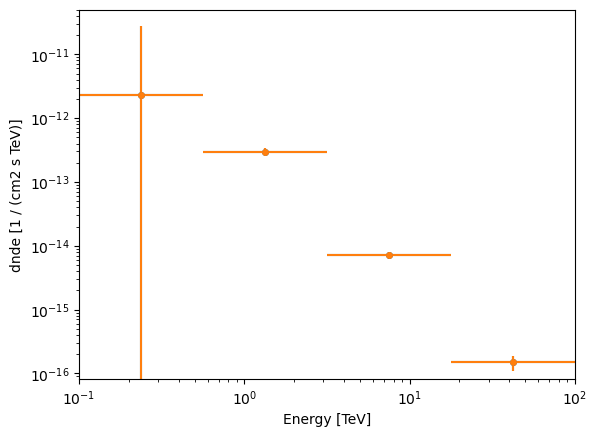

In [28]:
ax = fpoi_N.plot()
fpoi.plot(ax = ax)